In [194]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from lab_1_b import *
import pandas as pd
import seaborn as sns
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h
    
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
# Question 1

    # Generate data

n=2000
sigma = 0.15
mg_series_ground_truth = mackey_glass(tau=17, n=n, x0=1.5, N=10)
mg_series = mg_series_ground_truth + torch.randn(size=(n,1)) * sigma

    # Generate the time lagged input tensor and the output tensor

lower_bound, higher_bound = 300, 1500
inputs = []
inputs_test = []
lag = 20

for i in range(5):
    inputs.append(mg_series[lower_bound - lag : higher_bound - lag])
    inputs_test.append(mg_series_ground_truth[lower_bound - lag : higher_bound - lag])
    lag -= 5

inp = torch.stack(tensors=inputs, dim=1).squeeze()
inp_test = torch.stack(tensors=inputs_test, dim=1).squeeze()

out = mg_series[lower_bound - lag : higher_bound - lag]
out_test = mg_series_ground_truth[lower_bound - lag : higher_bound - lag]
    # Divide between train, val and test

ds_train = TensorDataset(inp[:800, :], out[:800])
ds_val = TensorDataset(inp_test[800:1000 , :], out_test[800:1000])
ds_test = TensorDataset(inp_test[1000:, :], out_test[1000:])

train_dataloader = DataLoader(ds_train, batch_size=16, shuffle=False)
val_dataloader = DataLoader(ds_val, batch_size=16, shuffle=False)
test_dataloader = DataLoader(ds_test, batch_size=200, shuffle=False)


In [226]:
# Question 2

h1, h2 = 3, 5
h1s = [3, 4, 5]
h2s = [3, 6, 9]
lr = 0.1
num_epochs = 30
loss_fn = nn.MSELoss()
val_losses = {}
h1 = 3
h2 = 3
weight_decays = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]


for weight_decay in weight_decays:
    losses = []
    for i in range(1, 30):
        mlp = MLP(input_size=5, output_size=1, hidden_size_1=h1, hidden_size_2=h2)
        optimizer = torch.optim.AdamW(lr=lr, weight_decay=weight_decay, params=mlp.parameters())
        mlp_trainer = RegularizedMLPTrainer(model=mlp, optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader=val_dataloader, patience=50, checkpoint_path='checkpoint' + str(i) + '.pt')
        training_losses, validation_losses = mlp_trainer.train(num_epochs=num_epochs)
        training_losses = [float(tl.detach().numpy()) for tl in training_losses]
        validation_losses = [float(vl.detach().numpy()) for vl in validation_losses]

        # title = 'h1 : ' + str(h1) + ' h2 : ' + str(h2)

        # X = np.arange(len(training_losses))
        
        # fig, ax = plt.subplots(1, 1)
        # ax.plot(X, training_losses, label='Training loss')
        # ax.plot(X, validation_losses, label='Validation loss')
        # ax.set_xlabel("epoch")
        # ax.set_ylabel("Loss")
        # ax.set_title(title)
        # plt.legend()
        losses.append(validation_losses[-1])
    # title += ' loss : ' + str(float(loss))
    # plot_preds(title=title, y_pred=y_pred.squeeze(), y=out[-200:])
    val_losses["weight_decay " + str(weight_decay)] = losses
val_losses

{'weight_decay 0.001': [0.28719744086265564,
  0.27429822087287903,
  0.1051434725522995,
  0.27817192673683167,
  0.29363128542900085,
  0.14592459797859192,
  0.2928345799446106,
  0.24140752851963043,
  0.2871568202972412,
  0.2663421630859375,
  0.109681136906147,
  0.2966691255569458,
  0.2981281578540802,
  0.26697733998298645,
  0.25422796607017517,
  0.20836497843265533,
  0.2758621573448181,
  0.28348106145858765,
  0.29222527146339417,
  0.23022934794425964,
  0.2962075173854828,
  0.29246777296066284,
  0.17865383625030518,
  0.23737327754497528,
  0.21323367953300476,
  0.28492504358291626,
  0.28310084342956543,
  0.14334677159786224,
  0.7200317978858948],
 'weight_decay 0.0001': [0.2662526071071625,
  0.14903080463409424,
  0.14104418456554413,
  0.24381740391254425,
  0.24134144186973572,
  0.2871709167957306,
  0.2718393802642822,
  0.2725188732147217,
  0.2823159694671631,
  0.16522124409675598,
  0.28790515661239624,
  0.17990411818027496,
  0.10829735547304153,
  0.

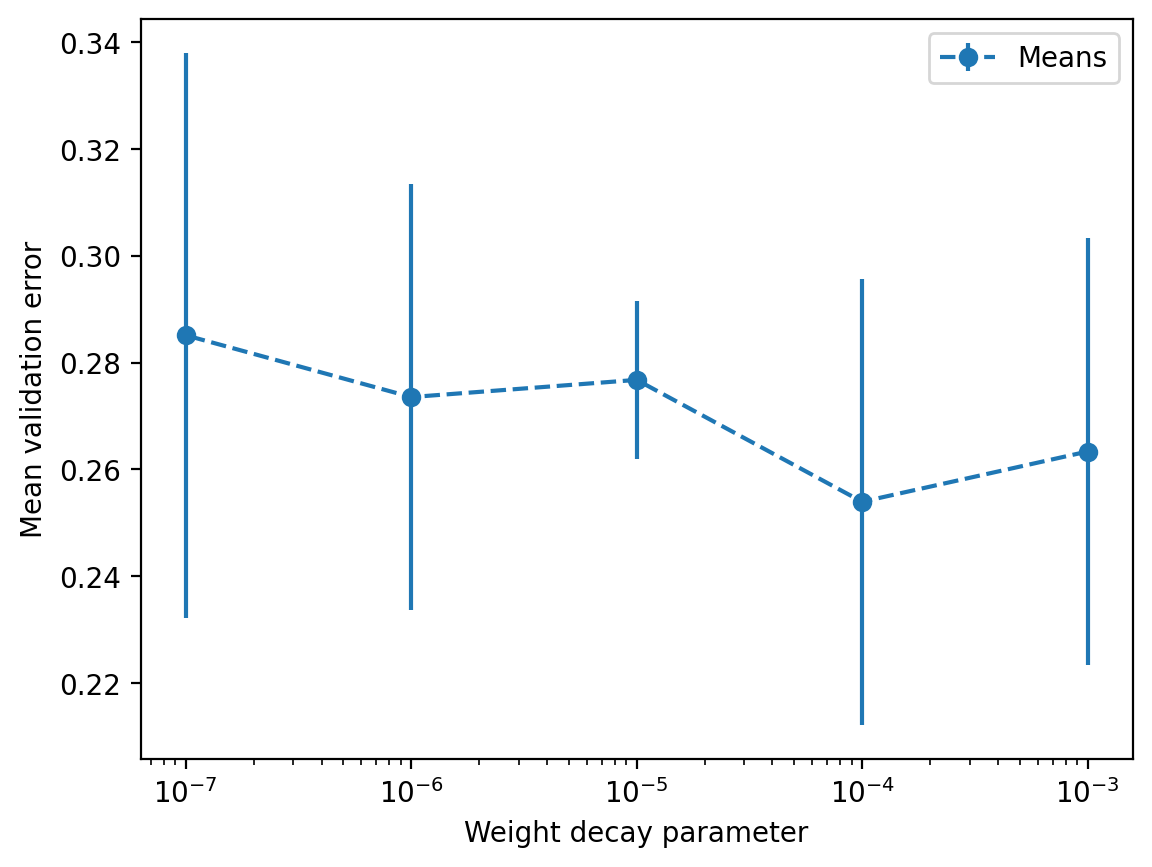

In [227]:
val_means = [mean_confidence_interval(l)[0] for l in val_losses.values()]
val_std = [mean_confidence_interval(l)[1] for l in val_losses.values()]

fig, ax = plt.subplots(1, 1)
ax.errorbar(x=weight_decays , y=val_means, yerr=val_std, fmt='--', label='Means', marker='o')
ax.set_xscale('log')
ax.set_xlabel("Weight decay parameter")
ax.set_ylabel("Mean validation error")
plt.legend()

(0.2113869379114623, 0.011751455795329158)
(0.20921407128223266, 0.01302440812856007)


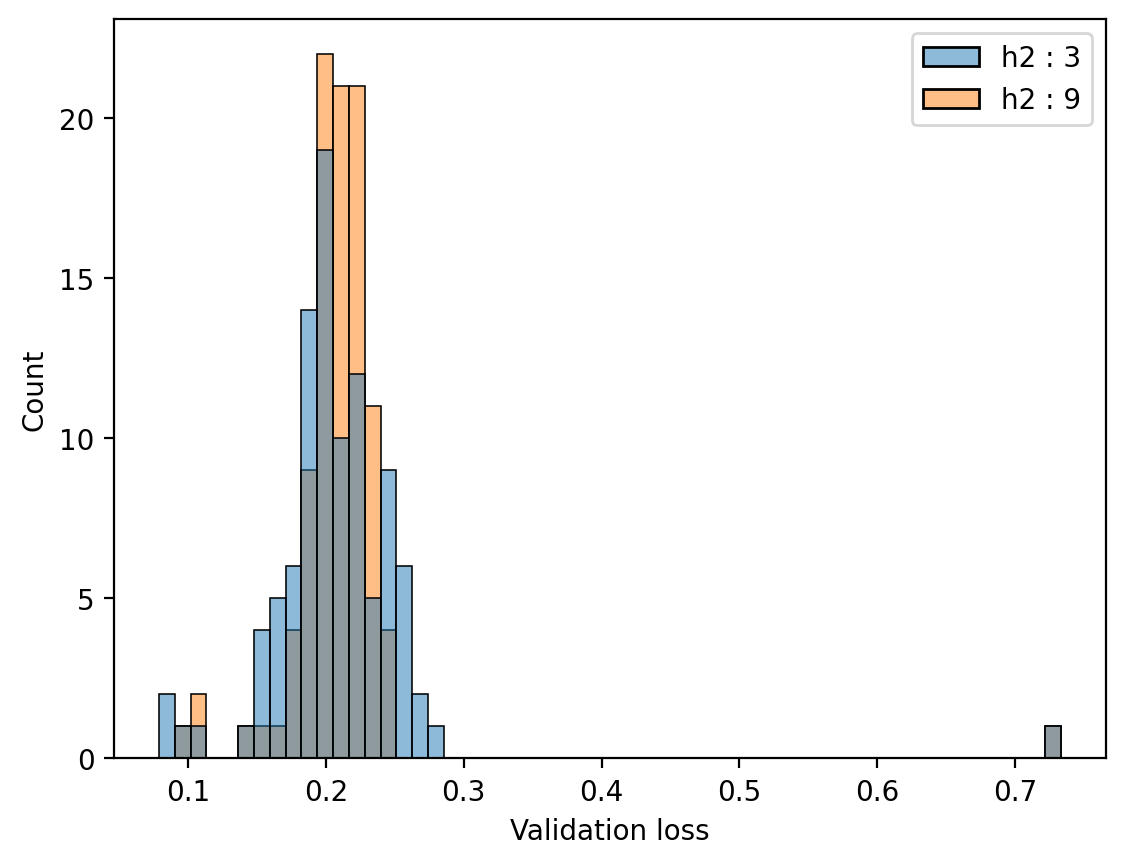

In [186]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

worse = 'h2 : 9'
best = 'h2 : 3'

w = pd.Series(val_losses[worse], name=worse)
b = pd.Series(val_losses[best], name=best)

df = pd.DataFrame()
df[best] = b
df[worse] = w

fig, ax = plt.subplots(1, 1)
sns.histplot(data=df, ax=ax)
ax.set_xlabel("Validation loss")


print(mean_confidence_interval(w))
print(mean_confidence_interval(b))

In [187]:


mlp_best = MLP(input_size=5, output_size=1, hidden_size_1=3, hidden_size_2=3)
optimizer = torch.optim.AdamW(lr=lr, weight_decay=1e-6, params=mlp_best.parameters())
mlp_trainer = RegularizedMLPTrainer(model=mlp_best, optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader=val_dataloader, patience=50, checkpoint_path='checkpoint' + str(i) + '.pt')
training_losses, validation_losses_b = mlp_trainer.train(num_epochs=num_epochs)

mlp_worse = MLP(input_size=5, output_size=1, hidden_size_1=3, hidden_size_2=9)
optimizer = torch.optim.AdamW(lr=lr, weight_decay=1e-6, params=mlp_worse.parameters())
mlp_trainer = RegularizedMLPTrainer(model=mlp_worse, optimizer=optimizer, train_dataloader=train_dataloader, val_dataloader=val_dataloader, patience=50, checkpoint_path='checkpoint' + str(i) + '.pt')
training_losses, validation_losses_w = mlp_trainer.train(num_epochs=num_epochs)

loss = torch.Tensor([0.])
loss_fn = nn.MSELoss()

with torch.no_grad():
    for x,y in test_dataloader:
        y_pred_b = mlp_best(x)
        y_pred_w = mlp_worse(x)
        mse_b = loss_fn(y_pred_b, y)
        mse_w = loss_fn(y_pred_w, y)

print("best loss : ", mse_b, "worse loss ", mse_w)
print(validation_losses_b[-1], validation_losses_w[-1])

best loss :  tensor(0.0102) worse loss  tensor(0.0147)
tensor([0.1349]) tensor([0.1841])


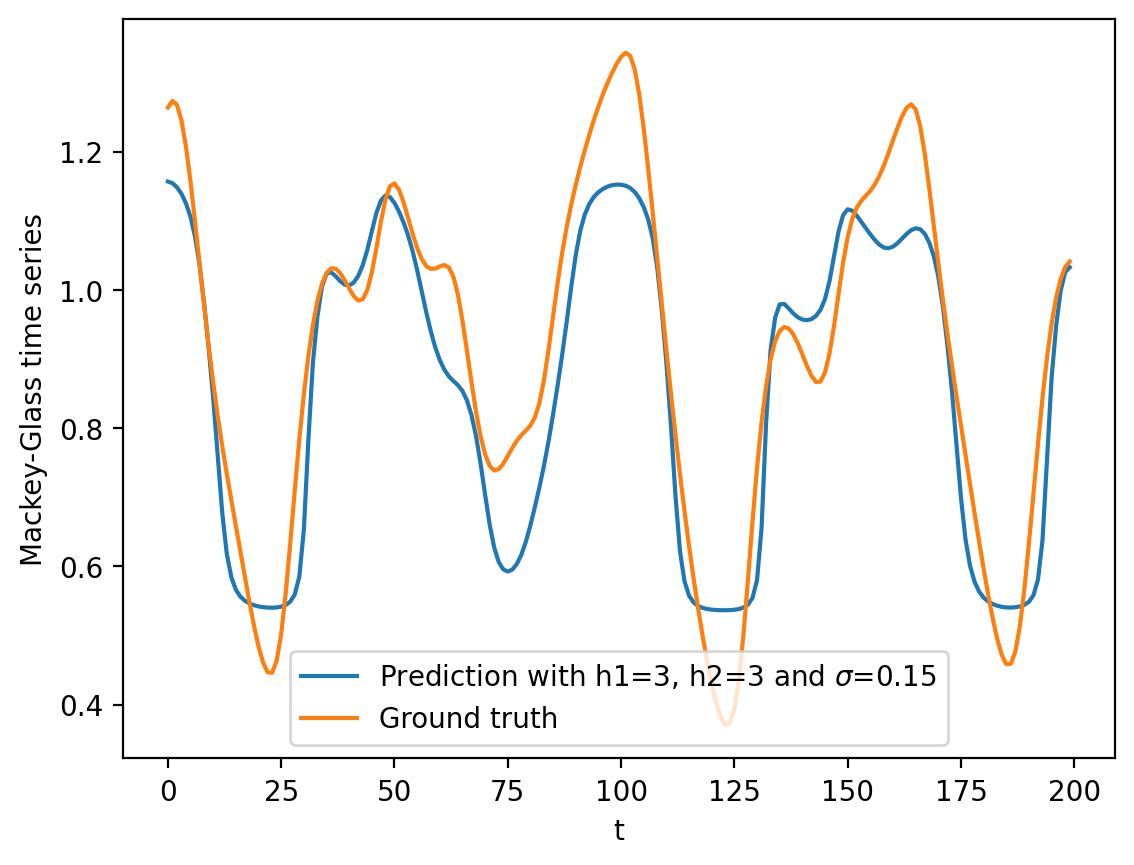

In [190]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(y_pred_b.squeeze().shape[0]) , y_pred_b.squeeze(), label='Prediction with h1=3, h2=3 and $\sigma$=0.15')
# ax.plot(np.arange(y_pred_w.squeeze().shape[0]) , y_pred_w.squeeze(), label='Worse prediction')
ax.plot(np.arange(y_pred_b.squeeze().shape[0]) , out_test[-200:], label='Ground truth')
ax.set_xlabel("t")
ax.set_ylabel("Mackey-Glass time series")
plt.legend()

Text(0, 0.5, 'Mackey-Glass time series')

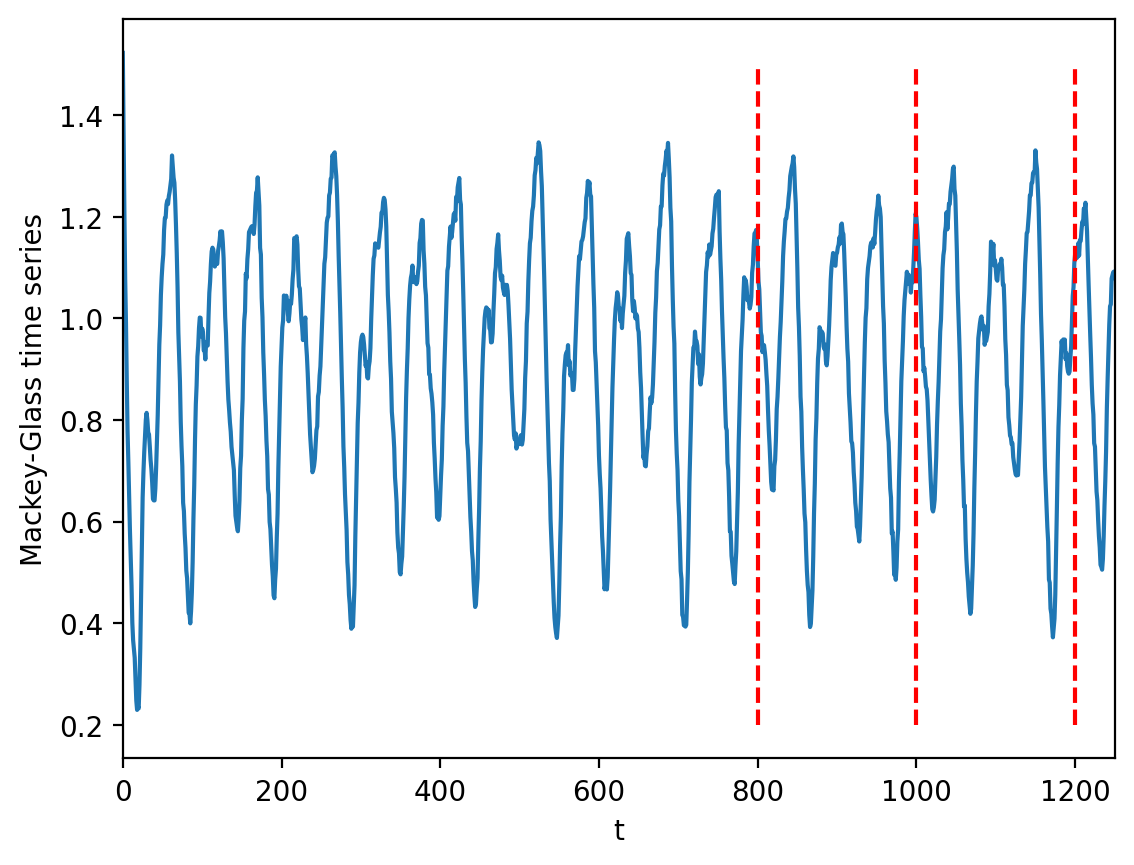

In [93]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0, n), mg_series)
ax.vlines([800, 1000, 1200], ymin=[0.2, 0.2, 0.2], ymax=[1.5, 1.5, 1.5], colors=['r', 'r', 'r'], linestyles='dashed')
ax.set_xlabel("t")
ax.set_xlim(0, 1250)
ax.set_ylabel("Mackey-Glass time series")